<h1 align="center">Introdução à implantação de ML: Flask, Docker e Locust</h1>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Aqui aprenderemos a implantar nossos modelos em `Python` e medir o desempenho usando o [Locust](https://docs.locust.io/en/stable/what-is-locust.html#what-is-locust).

# Introdução

Você gastou muito tempo no [EDA](https://www.analyticsvidhya.com/blog/2021/04/rapid-fire-eda-process-using-python-for-ml-implementation/), elaborou cuidadosamente suas features, ajustou seu modelo por dias e, finalmente, tem algo que funciona bem no conjunto de `teste`. <font color="red">O que agora?</font> Agora, meu amigo, precisamos implantar o modelo. Afinal, qualquer modelo que fica no notebook tem valor zero, por melhor que seja.


A seguinte imagem é só para lembrar do processo de Machine Learning:


![](https://editor.analyticsvidhya.com/uploads/39379DS-flow.png)


Na preparação de Dados, a EDA, muitas vezes demanda muito tempo já que precisamos de um conjunto de Dados "ideal" e assim obter um bom modelo em produção. 


![](https://editor.analyticsvidhya.com/uploads/24537Zoom-EDA.png)

Pode parecer difícil aprender essa parte do fluxo de trabalho da ciência de dados, especialmente se você não tiver muita experiência em engenharia de software. Não tema, o objetivo principal desta postagem é apresentar uma das estruturas mais populares para implantação em `Python — Flask`. Além disso, você aprenderá como `conteinizar` a implantação e medir seu desempenho, duas etapas frequentemente negligenciadas.



# O que é “implantação” afinal?

Em primeiro lugar, vamos esclarecer o que quero dizer com implantação (`Deployment`) neste post. A implantação de ML é o processo de pegar um modelo treinado e integrá-lo a um sistema de produção (`servidor` no diagrama abaixo), tornando-o disponível para uso por usuários finais ou outros sistemas.

![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*nsMgGA2Fupz9YM0CH2XM2w.png)

<font color="pink">Lembre-se de que, na realidade, o processo de implantação é muito mais complicado do que simplesmente disponibilizar o modelo para os usuários finais.</font> Também envolve integração de serviços com outros sistemas, seleção de uma infraestrutura apropriada, balanceamento de carga e otimização e testes robustos de todos esses componentes. A maioria dessas etapas está fora do escopo desta postagem e, idealmente, deve ser tratada por `engenheiros de software/ML` experientes. No entanto, é importante ter algum entendimento sobre essas áreas, e é por isso que esta postagem abordará `conteinerização`, `teste de velocidade de inferência` e `manuseio de carga`.


# Setup (Configuração)

Todo o código, original, pode ser encontrado no repositório do GitHub de [Antons Tocilins-Ruberts](https://github.com/aruberts/tutorials/tree/main/deployment/flask). Certifique-se de puxá-lo e experimentá-lo, essa é a melhor maneira de aprender. Para executar o código, você precisará de — `docker`, `flask`, `fastapi` e `locust` instalado. Pode haver algumas dependências adicionais para instalar, dependendo do ambiente em que você está executando este código.

# Visão Geral do Projeto (Project Overview)

Para tornar o aprendizado mais prático, este post mostrará uma demonstração simples de implementação de um modelo de previsão de `inadimplência` (falta de cumprimento de uma obrigação). O processo de treinamento do modelo está fora do escopo desta postagem, portanto, o modelo `CatBoost` já treinado e serializado está disponível no repositório do GitHub. O modelo foi treinado no conjunto de dados pré-processado [US Small Business Administration (licença CC BY-SA 4.0)](https://www.kaggle.com/datasets/mirbektoktogaraev/should-this-loan-be-approved-or-denied). Sinta-se à vontade para explorar o dicionário de dados para entender o que significa cada uma das colunas.


Este projeto se concentra principalmente na parte de `servir`, ou seja, `disponibilizar o modelo para outros sistemas`. Portanto, o modelo será realmente implantado em sua máquina local, o que é bom para testes, mas não é ideal para o mundo real. Aqui estão as principais etapas que as implantações para `Flask` e `FastAPI` seguirão:


<font color="yellow">1.</font> Criar endpoint de API (`usando Flask ou FastAPI`)

<font color="yellow">2.</font> `Containerize` o aplicativo (endpoint) usando o `Docker`

<font color="yellow">3.</font> Execute a imagem do Docker localmente, criando um servidor (server)

<font color="yellow">4.</font> Teste o desempenho do servidor (server performance)

![](https://miro.medium.com/v2/resize:fit:640/format:webp/1*MrS0TY9zFbzC2OX1YvBz_Q.png)

# O que é Flask?

O `Flask` é uma estrutura da Web popular e amplamente adotada para Python devido à sua **natureza leve** e aos requisitos mínimos de instalação. Ele oferece uma abordagem direta para desenvolver `REST APIs` que são ideais para atender a modelos de Machine Learning.

O fluxo de trabalho típico do `Flask` envolve definir um ponto de extremidade HTTP de previsão e vinculá-lo a funções Python específicas que recebem dados como entrada e geram previsões como saída. Esse endpoint pode então ser acessado por usuários e outros aplicativos.

# Criar Aplicativo Flask (Create Flask App)

Se você estiver interessado em simplesmente criar um endpoint de `previsão`, será bem simples. Tudo o que você precisa fazer é desserializar o modelo, criar o objeto `Flask` do aplicativo e especificar o endpoint de previsão com o método `POST`. Mais informações sobre POSTe outros métodos você pode encontrar [aqui](https://pythonbasics.org/flask-http-methods/).

```
import catboost as cb
import pandas as pd

from flask import Flask, jsonify, request

# Load the model
model = cb.CatBoostClassifier()
model.load_model("loan_catboost_model.cbm")

# Init the app
app = Flask("default")


# Setup prediction endpoint
@app.route("/predict", methods=["POST"])
def predict():
    # Get the provided JSON
    X = request.get_json()
    # Perform a prediction
    preds = model.predict_proba(pd.DataFrame(X, index=[0]))[0, 1]
    # Output json with prediction
    result = {"default_proba": preds}
    return jsonify(result)


if __name__ == "__main__":
    # Run the app on local host and port 8989
    app.run(debug=True, host="0.0.0.0", port=8989)
```
    

A parte mais importante do código acima é a função `predict`. Ele lê a entrada `json` que, neste caso, é um conjunto de atributos que descrevem um pedido de empréstimo. Em seguida, ele pega esses dados, os transforma no `DataFrame` e os passa pelo modelo. A `probabilidade resultante` de um padrão é então formatada de volta em json e retornada. Quando esse aplicativo é implantado localmente, podemos obter a previsão enviando uma solicitação com dados formatados em json para a URL http://0.0.0.0:8989/predict. 

Vamos experimentar! 

Para iniciar o servidor, podemos simplesmente executar o arquivo `Python` com o comando abaixo:

```
python app.py
```

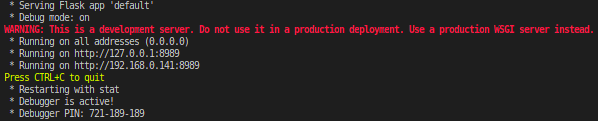

Quando este comando for executado, você deve receber a mensagem de que seu aplicativo está sendo executado no endereço http://0.0.0.0:8989/. Por enquanto, vamos ignorar um grande aviso vermelho e testar o aplicativo. Para verificar se o aplicativo está funcionando conforme o esperado, podemos enviar uma solicitação de teste (dados do aplicativo de empréstimo) para o aplicativo e ver se obtemos uma resposta (previsão de probabilidade padrão) em retorno.


```
# Example loan application
application = {
    "Term": 84,
    "NoEmp": 5,
    "CreateJob": 0,
    "RetainedJob": 5,
    "longitude": -77.9221,
    "latitude": 35.3664,
    "GrAppv": 1500000.0,
    "SBA_Appv": 1275000.0,
    "is_new": True,
    "FranchiseCode": "0",
    "UrbanRural": 1,
    "City": "Other",
    "State": "NC",
    "Bank": "BBCN BANK",
    "BankState": "CA",
    "RevLineCr": "N",
    "naics_first_two": "45",
    "same_state": False,
}

# Location of my server
url = "http://0.0.0.0:8989/predict"

# Send request
resp = requests.post(url, json=application)

# Print result
print(resp.json())
```


Se você conseguiu obter uma resposta com probabilidade - parabéns! 

Você implantou o modelo usando seu próprio computador como servidor. Agora, vamos acelerar e empacotar seu aplicativo de implantação usando o `Docker`.

# Conteinerização de Flask App

A `conteinerização` é o processo de `encapsular seu aplicativo` e todas as suas dependências (incluindo Python) em um pacote independente e isolado que pode ser executado de forma consistente em diferentes ambientes (<font color="red">por exemplo:</font> localmente, na nuvem, no laptop de seu amigo, etc.). Você pode conseguir isso com o `Docker` e tudo o que precisa fazer é especificar corretamente o `Dockerfile`, criar a imagem e executá-la. O `Dockerfile` fornece instruções ao seu contêiner, <font color="yellow">por exemplo:</font> qual versão do Python usar, quais pacotes instalar e quais comandos executar. Há um ótimo tutorial em vídeo de [Abhishek Thakur](https://www.youtube.com/watch?v=0qG_0CPQhpg&t=138s) sobre o Docker se você estiver interessado em saber mais.

Veja como pode ser a aparência do `Aplicativo Flask` acima.